## Overview

This analysis is based on the attributes of football players released on [FIFA19](https://www.kaggle.com/karangadiya/fifa19)  dataset on Kaggle. In this project, we perform data analysis using **Spark packages**.
 

In this analysis, we divide the task into three parts.

- **Part 1**: Exploratory Data Analysis

- **Part 2**: Clustering Analysis, and identify the position profiles of each cluster

- **Part 3**: Classification Analysis, and evaluate the performance of different algorithms using cross-validation

## Part 1 - Exploratory Data Analysis

### 1.0. Libraries and data files
***

In [1]:
!apt-get update
# importing the necessary spark environment and getting jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
import os
# setting up the environment variables
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-2.4.0-bin-hadoop2.7'

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [67.9 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 h

In [ ]:
#only required for jupyter, do not run this cell on google colab
import os
os.environ['SPARK_HOME'] = 'D:/Projects/spark-2.4.0-bin-hadoop2.7'

In [2]:
# getting the data
!pip install -q wget
!pip install -q findspark
import wget
data_19 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_19_players.csv'
dataset_19 = wget.download(data_19)

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

### 1.1 Data Exploration
***

In [4]:
# importing the 'FIFA_19.csv' as a Spark dataframe
spark = SparkSession.builder.appName('FIFA_19').config('spark.sql.caseSensitive', 'true').getOrCreate()
sc = spark.sparkContext
# not including header as data while reading so the header value is made true
df_19 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_19_players.csv')
df_19.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate| Body 

In [5]:
df_19.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- value(M): string (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)
 |-- Contract 

**Checking the Statistics (min, mean and max) for Age, Overall:**

In [6]:
# use aggregate to calculate min, max and mean

# calculating the minimum age
min_age = df_19.agg({'Age':'min'}).show()

# calculating the maximum age
max_age = df_19.agg({'Age':'max'}).show()

# calculating the mean age
mean_age = df_19.agg({'Age':'avg'}).show()

+--------+
|min(Age)|
+--------+
|      16|
+--------+

+--------+
|max(Age)|
+--------+
|      45|
+--------+

+------------------+
|          avg(Age)|
+------------------+
|25.122205745043114|
+------------------+



In [7]:
# calculating the minimum overall
min_overall = df_19.agg({'Overall':'min'}).show()

# calculating the maximum overall
max_overall = df_19.agg({'Overall':'max'}).show()

# calculating the mean overall
mean_overall = df_19.agg({'Overall':'avg'}).show()

+------------+
|min(Overall)|
+------------+
|          46|
+------------+

+------------+
|max(Overall)|
+------------+
|          94|
+------------+

+-----------------+
|     avg(Overall)|
+-----------------+
|66.23869940132916|
+-----------------+



**Finding the Position with the Highest Average Overall:**

In [8]:
# grouping the data first by Position, aggregating the Overall and sorting the data to get the position the with highest overall 
df_overall_position = df_19.groupby('Position').agg({'Overall':'AVG'})
df_overall_position.orderBy(df_overall_position['avg(Overall)'].desc()).take(1)
#df_overall_position.sort('avg(Overall)',ascending=False).first()

[Row(Position='LF', avg(Overall)=73.86666666666666)]

**Finding the Top 3 Countries with the Highest Avg Overall:**

In [9]:
# grouping first by Countries and aggregating the Overall and sorting to get the top 3 countries with the highest average overall
df_overall_nationality = df_19.groupby('Nationality').agg({'Overall':'AVG'})
df_overall_nationality.orderBy(df_overall_nationality['avg(Overall)'].desc()).take(3)

[Row(Nationality='United Arab Emirates', avg(Overall)=77.0),
 Row(Nationality='Central African Rep.', avg(Overall)=73.33333333333333),
 Row(Nationality='Israel', avg(Overall)=72.14285714285714)]

**Finding the Average Potential for a Country by Position:**

In [10]:
# creating a pivot table in which the value of column Nationality is transposed to multiple columns 
pivot_df = df_19.groupBy('Position').pivot('Nationality').avg('Potential')
pivot_df.show(pivot_df.count())

+--------+-----------+-----------------+-----------------+-------+-----------------+-----------------+-----------------+-------+-----------------+-----------------+----------+--------+-------+-----------------+------+-----------------+-------+-------+------------------+--------+-----------------+--------+-----------------+-------+-----------------+-----------------+----------+--------------------+----+------------------+------------------+-----------------+-------+-----------------+-----------------+-----------------+----+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+-----------------+-------+-----------------+--------+-----------------+-------------+----+-----------------+-----------------+-----+------+-----------------+-----------------+-----------------+-----------------+-------+----+---------+------+-----------------+------+-----------------+--------+---------+----

Further, viewing the highest average potential for each position.

In [11]:
# renaming the name of a country to avoid syntax error in the next stage
pivot_df = pivot_df.withColumnRenamed('Central African Rep.', 'Central African Republic')

In [12]:
# removing the null position from the dataframe
pivot_df = pivot_df.filter((pivot_df.Position != 'NA'))
pivot_df.show(pivot_df.count())

+--------+-----------+-----------------+-----------------+-------+-----------------+-----------------+-----------------+-------+-----------------+-----------------+----------+--------+-------+-----------------+------+-----------------+-------+-------+------------------+--------+-----------------+--------+-----------------+-------+-----------------+-----------------+----------+------------------------+----+-----------------+------------------+-----------------+-------+-----------------+-----------------+-----------------+----+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+-----------------+-------+-----------------+--------+-----------------+-------------+----+-----------------+-----------------+-----+------+-----------------+-----------------+-----------------+-----------------+-------+----+---------+------+-----------------+------+-----------------+--------+---------+-

In [13]:
# finding the maximum value for each row from all columns excluding Position
from pyspark.sql.functions import greatest, col, lit, coalesce, sum
#rowmax = sum([coalesce(col(x), lit(0)) for x in pivot_df.columns])
rowmax = greatest(*[coalesce(col(x), lit(0)) for x in pivot_df.columns[1:]]) 
# adding the column containing maximum values
pivot_df.withColumn('Position(Maximum_Potential)',rowmax).show(pivot_df.count())

+--------+-----------+-----------------+-----------------+-------+-----------------+-----------------+-----------------+-------+-----------------+-----------------+----------+--------+-------+-----------------+------+-----------------+-------+-------+------------------+--------+-----------------+--------+-----------------+-------+-----------------+-----------------+----------+------------------------+----+-----------------+------------------+-----------------+-------+-----------------+-----------------+-----------------+----+-------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+-----------------+-------+-----------------+--------+-----------------+-------------+----+-----------------+-----------------+-----+------+-----------------+-----------------+-----------------+-----------------+-------+----+---------+------+-----------------+------+-----------------+--------+---------+-

Finding the name of countries with the highest average potential for each position is better for understanding. So, we discover the countries having players with the highest average potential for each position.  

In [14]:
from pyspark.sql import types as T
from pyspark.sql import functions as F
from pyspark.sql.window import Window as W

# creating a dataframe with a column whose values contain an array of country name and average potential value
pdf = pivot_df.withColumn('Maximum_Avg_Potential',F.explode( \
        F.array([F.array([F.lit(cols), F.col(cols)]) for cols in pivot_df.columns[1:]])))

# creating a dataframe such that the country name and avg potential values are separated in two columns
pdf = pdf.select('Position', F.col('Maximum_Avg_Potential').getItem(0).alias('Country'), \
                 F.col('Maximum_Avg_Potential').getItem(1).cast(T.IntegerType()).alias('Avg_Potential'))

# creating a rank based on average potential for each position in descending order
pdf = pdf.withColumn('Rank', F.rank().over(W.partitionBy('Position').orderBy(F.col('Avg_Potential').desc())))

# selecting rows with rank equal to 1 and this gives the maximum average potential value 
pdf.where('Rank=1').show(pdf.count())

+--------+--------------------+-------------+----+
|Position|             Country|Avg_Potential|Rank|
+--------+--------------------+-------------+----+
|      RF|           Argentina|           87|   1|
|     LWB|            Portugal|           82|   1|
|     LCM|            Slovakia|           87|   1|
|      LM|               Gabon|           82|   1|
|     RDM|      Czech Republic|           83|   1|
|      LF|             Belgium|           86|   1|
|     CAM|            Slovakia|           80|   1|
|     RAM|             Morocco|           86|   1|
|      LB|             Ukraine|           76|   1|
|      LW|        Burkina Faso|           84|   1|
|     RCM|                Mali|           84|   1|
|      GK|             Nigeria|           82|   1|
|      RB|              Panama|           80|   1|
|      RS|            Cameroon|           81|   1|
|     LCB|              Gambia|           81|   1|
|      CM|Central African R...|           85|   1|
|      RW|              Kosovo|

The most interesting finding from the above dataframe is that the Dominican Republic has the highest average potential for the striker position. It is well known that, unlike European, South American or African continents, players from other continents rarely make it to the big stage. So, it can be assumed that the player is an outlier, and is among the few players with the highest ratings in that country. Not many scouts might be well aware of that striker. It is good to observe that player's game and see if we can sign that player and make one of the prospects in football.

In [15]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

#df_view = 'soccer_analysis'
df_19.createOrReplaceTempView('soccer_analysis')

In [16]:
# viewing the players from Dominican Republic
spark.sql("""
          Select * from soccer_analysis where Nationality = 'Dominican Republic'
          """).show()

+------+----------+---+--------------------+------------------+--------------------+-------+---------+-----------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|      Name|Age|               Photo|       Nationality|                Flag|Overall|Potential|       Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|   Work Rate|Body Type|Real Face|Positio

It is seen that there are only two players from Dominican Republic in the FIFA 2019 database. And, the player with the highest potential as a striker is Mariano who is 24 years old. Since he has already signed for one of the top clubs in Europe, it is hard to lure him away from the club. The release clause of 42.5 million is moderate considering the current market in 2019. 

**Finding the Position with the Highest Average Potential for Australia:** 

In [17]:
# selecting the highest average Potential along with the position for Australia
pivot_df.createOrReplaceTempView('pivot_soccer_analysis')
spark.sql("""
          Select Position, Australia from pivot_soccer_analysis Order By Australia Desc Limit 1
          """).show(30)

+--------+---------+
|Position|Australia|
+--------+---------+
|     RDM|     77.0|
+--------+---------+



In [18]:
# finding the name of the Australian player with the highest average potential 
spark.sql("""
          Select * from soccer_analysis Where Nationality = 'Australia' And Position = 'RDM'
          """).show()

+------+---------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|     Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|   Work Rate|Body Type|Real Face|Positio

**Finding the Under 20 Players with the Highest and Worst Potential:**

In [19]:
# filtering the dataset based on age (under 20) and then arranging the overall in descending order
spark.sql("""
          Select * from soccer_analysis Where Age < 20 Order By Overall Desc
          """).show()

+------+-------------------+---+--------------------+-------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|               Name|Age|               Photo|  Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Ra

It is found that the best player under 20 player is Kylian Mbappe, and he has the best potential as well. 

In [20]:
# under 20 players having the worst potential
spark.sql("""
          Select * from soccer_analysis Where Age < 20 Order By Potential Asc
          """).show()

+------+-------------+---+--------------------+-------------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|         Name|Age|               Photo|        Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Ra

In [21]:
# finding the Australian player with the highest potential
spark.sql("""
          Select * from soccer_analysis Where Nationality = 'Australia' Order By Potential Desc
          """).show()

+------+-------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+--------------------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|         Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate|Body

In [22]:
# finding the Australian player with the lowest potential
spark.sql("""
          Select * from soccer_analysis Where Nationality = 'Australia' Order By Potential Asc
          """).show()

+------+--------------+---+--------------------+-----------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|          Name|Age|               Photo|Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate|Body Type|R

**Relationship between Age of Players with their Potential and Overall:**

In this part, we aim to find the relationship between age and average potential and age and average overall.

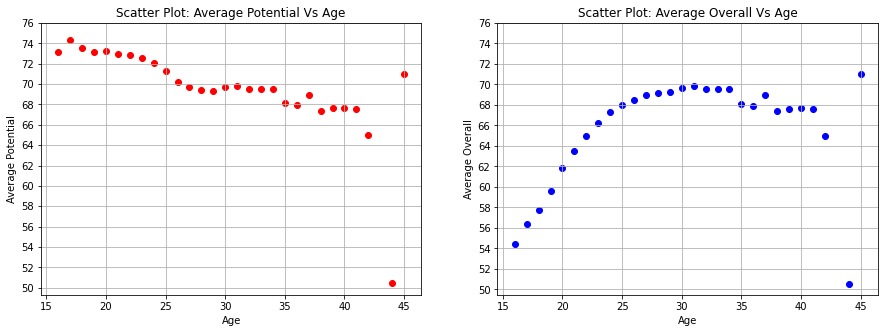

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# creating two dataframes that hold Age with Average Potential and Average Overall along with renaming the aggregated columns
df_age_potential = df_19.groupby('Age').avg('Potential').withColumnRenamed('avg(Potential)', 'Average Potential')
df_age_overall = df_19.groupby('Age').avg('Overall').withColumnRenamed('avg(Overall)', 'Average Overall')

# first, converting the above two pyspark dataframes to Pandas and storing in a variable
# then, concatenating those two pandas dataframe setting axis 1 i.e. by column
data = [df_age_potential.select('*').toPandas(),df_age_overall.select('Average Overall').toPandas()]
df_age = pd.concat(data, axis=1)
df_age.head(5)

# plotting 
# creating two subplots for plotting Average Potential and Average Overall against Age
fig, (ax1,ax2) = plt.subplots(1, 2, sharex='none', sharey='none', figsize=(15,5))
# using first scatter plot for Average Potential and the second for Average Overall 
ax1.scatter(df_age['Age'], df_age['Average Potential'], color='r')
ax2.scatter(df_age['Age'], df_age['Average Overall'], color='b')
# setting y ticks, labels and titles for both plots
ax1.set_yticks(list(range(50,78,2)))
ax2.set_yticks(list(range(50,78,2)))
ax1.set_xlabel('Age')
ax1.set_ylabel('Average Potential')
ax1.set_title('Scatter Plot: Average Potential Vs Age')
ax2.set_xlabel('Age')
ax2.set_ylabel('Average Overall')
ax2.set_title('Scatter Plot: Average Overall Vs Age')
# enabling grid view
ax1.grid(True)
ax2.grid(True)
plt.show()

It is seen from the above scatter plots that the average potential decreases with age while the average overall increases with age. At age 31, both average potential and average overall meet at the same point (70). So, by the age of 31, players will realise their full potential. After 31, both average potential and average overall declines. However, we can see that at 45 both average potential and overall reached a high point which can be considered as an outlier.

In [24]:
# finding the correlation matrix
df_age.corr(method ='pearson') 

,Age,Average Potential,Average Overall
Age,1.000000,-0.703127,0.370369
Average Potential,-0.703127,1.000000,0.199843
Average Overall,0.370369,0.199843,1.000000


The above correlation matrix reflects the same relationship that can be seen in scatter plots.

**Dealing Missing Values:**

In this stage, we examine the dataset to see the necessary operations required on data to ease our analysis. 

In [25]:
# checking the missing values
from pyspark.sql.functions import count, col
null_values_count = df_19.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in df_19.columns])
null_values_count.show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|HeadingAccuracy|ShortPassing|Vo

In this analysis, the attributes that we are concerned with are player attributes that have impacts on players' gameplay such as 'Crossing', ShortPassing', etc. We are only concerned with forwards, midfielders and defenders, not goalkeepers. It is seen that all attributes of interests have 48 missing values which include goalkeeping attributes too (GKDiving). So, we need to see if those missing values for different attributes belong to goalkeepers only before performing imputation or deletion of missing values.

In [26]:
# checking the missing values after removing goalkeepers
df_non_goalkeeper = df_19.filter(df_19['Position'] != 'GK')
df_non_goalkeeper.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in df_19.columns]).show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|HeadingAccuracy|ShortPassing|Vo

It is seen that no missing values are present in our many attributes of interests for players belonging to positions other than goalkeepers. So, we create a new dataframe without goalkeepers for our later analysis.

In [27]:
# removing the position GK and storing in a new dataframe
df_19 = df_19.filter(df_19['Position'] != 'GK')
df_19.cache()
df_19.count()

16122

## Part 2 - Unsupervised Learning: Kmeans




### 2.1 Data Preparation
***

In this stage, we perform clustering of players after grouping them in three groups, DEF, MID and FWD, based on their attributes. Later, we analyse what type of positions are mainly included in each cluster.

To make the later stage easier, we define the position group by using the position feature (attributes on Position).
- DEF = [LB,LWB,RB,LCB,RCB,CB,RWB] ,
- FWD = [RF,LF,LW,RS,RW,LS,CF,ST] ,
- MID = [LCM,LM,RDM,CAM,RAM,RCM,CM,CDM,RM,LAM,LDM]

In [28]:
from pyspark.sql.functions import when,col

# creating a list of specific positions
DEF = ['LB','LWB','RB','LCB','RCB','CB','RWB']
FWD = ['RF','LF','LW','RS','RW','LS','CF','ST']  
MID = ['LCM','LM','RDM','CAM','RAM','RCM','CM','CDM','RM','LAM','LDM'] 

# creating a new column which stores values based on conditions
df_kmeans_new = df_19.withColumn('Position_Group',F.when(F.col('Position').isin(DEF),'DEF')\
                                  .when(F.col('Position').isin(FWD),'FWD')\
                                  .when(F.col('Position').isin(MID),'MID').otherwise(0))
# checking if correct group has been assigned for specific playing positions
df_kmeans_new.select('Position','Position_Group').distinct().show(50)

+--------+--------------+
|Position|Position_Group|
+--------+--------------+
|     LCB|           DEF|
|      LS|           FWD|
|     RCB|           DEF|
|      ST|           FWD|
|      CF|           FWD|
|     RAM|           MID|
|     RCM|           MID|
|     LCM|           MID|
|      CM|           MID|
|      LF|           FWD|
|      RW|           FWD|
|      LB|           DEF|
|     CDM|           MID|
|     LDM|           MID|
|     RDM|           MID|
|      LM|           MID|
|     LWB|           DEF|
|      RB|           DEF|
|      LW|           FWD|
|      RS|           FWD|
|     LAM|           MID|
|     RWB|           DEF|
|      RM|           MID|
|      CB|           DEF|
|      RF|           FWD|
|     CAM|           MID|
+--------+--------------+



Now, we create a feature vector from the different features of a player. We only take the feature vector for clustering purposes removing the Position_Group and Position to create the feature for Kmeans




In [48]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

features_col = ['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
# selecting only ID and features, which is the feature vector in a new dataframe
df_kmeans = vec_assembler.transform(df_kmeans_new).select('ID','features')

# scaling the features
standard_scaler = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
scaled_data = standard_scaler.fit(df_kmeans).transform(df_kmeans).select('ID', 'features', 'Scaled_features')
scaled_data.show(5, False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ID    |features                                                                                                                                                             |Scaled_features                                                                    

Now we plot the elbow plot to determine the optimum number of clusters for our dataset. We test with a range of cluster numbers from 2 to 20.

In [51]:
# creating an array to store the within sum of squared errors for different cluster numbers
cost = np.zeros(21)

for k in range(2,21):
    # initialising k means with seed value to enable reproducability and fitting the model to df_kmeans
    kmeans_iter = KMeans(featuresCol='Scaled_features').setK(k).setSeed(2020)
    model = kmeans_iter.fit(scaled_data)
    # storing the within sum of squared errors in the cost array
    cost[k] = model.computeCost(scaled_data)

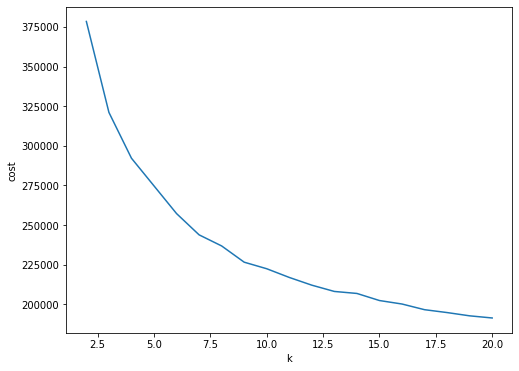

In [52]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.set_xlabel('k')
ax.set_ylabel('cost')

#plotting the within sum of squared errors for each cluster number
ax.plot(range(2,21),cost[2:21])

From the above plot, it can be seen that after k=8 there is not a steep decline in the cost (sum of squared error), so we take k=8 as our elbow point. For clustering, we take 8 as the ideal number of clusters.


### 2.2 K-Means
***



In [58]:
k = 9

kmeans = KMeans(featuresCol='Scaled_features').setK(k).setSeed(2020)
model = kmeans.fit(scaled_data)
# assigning the cluster centers
print('***Cluster Centres***')
cluster_centers = model.clusterCenters()
for i in cluster_centers:
  # printing the centers
  print(i) 

***Cluster Centres***
[13.52904155 11.90109526  3.61692147  4.24447582  5.92860569  6.34051701
  4.26719857  5.24534546  3.62713989  3.15416713  3.93773744  6.73621384
  5.71209342  6.02677508  5.29564969  7.51562872  4.94410832  5.36593475
  6.09241221  6.02386986  6.04495574  3.98911608  4.15157806  1.566461
  4.75450561  4.52336157  5.22674795  6.42153496  1.83688185  1.45662142
  1.26637403]
[12.92052443 11.1726164   4.8617338   3.61476896  5.31443513  7.64426326
  4.00025522  5.70312959  4.4761415   4.1922466   5.76975933  7.39953236
  5.83461787  5.90991019  5.73198907  8.25428783  5.75656146  5.53057647
  5.94387361  6.83456076  5.56809885  4.33006768  4.99501769  3.68519044
  4.52754637  5.44096573  4.91292397  7.09001286  3.86544088  3.61900719
  3.45365608]
[13.79170201 11.86710516  2.30270943  1.50730792  5.35967014  5.10935844
  1.85764387  2.86239695  1.9239025   1.89589648  3.45924413  4.61622047
  4.66726397  4.90940523  3.93475499  6.37829897  4.33737326  3.20729936
  5

In [185]:
# creating a table from the cluster centres
main_ele = []
for i in range(len(cluster_centers)):
  elements = cluster_centers[i].tolist()
  main_ele+=[elements]

rdd_cc = sc.parallelize(main_ele)
df_cc = rdd_cc.toDF(features_col)
df_cc.show()

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|        Height(CM)|        Weight(KG)|          Crossing|         Finishing|   HeadingAccuracy|      ShortPassing|           Volleys|         Dribbling|             Curve|        FKAccuracy|       LongPassing|      BallControl|      Acceleration|       SprintSpeed|           Agility|         Reactions|           Balance|        ShotPower|          Jumping|           Stamina|          Strength|         LongSh

From the analysis of cluster centres for different clusters, it is found that the first cluster might not contain defenders at all as the main attributes for defenders, which are ‘standing tackle’ and ‘sliding tackle’ have been given fewer points. On the other hand, it can be speculated that the third cluster is populated mostly by defenders as the defensive attributes are given high points while the forward attributes such as dribbling and volley are given fewer points. So, this cluster might contain more defenders and fewer forwards. In the second cluster, both defensive and forward attributes are given decent points but the higher points are given for attributes such as ‘short passing’, ‘ball control’ and ‘stamina’. This suggests that this cluster is dominated by midfielders. We will check this analysis against the result we obtain later to divide clusters based on positions.

In [59]:
# assigning the unique column to a cluster center while taking off the features column using transform and select method
predictions = model.transform(scaled_data).select('ID','prediction')
# assigning the list of predicted ids
predictions_list = predictions.collect()

# # instantiating a sqlContext object
# creating a dataframe using SQLContext object
df_prediction = sqlContext.createDataFrame(predictions_list)
df_prediction.show(10)

+------+----------+
|    ID|prediction|
+------+----------+
|158023|         4|
| 20801|         4|
|190871|         4|
|192985|         1|
|183277|         4|
|177003|         1|
|176580|         1|
|155862|         1|
|188545|         4|
|182521|         1|
+------+----------+
only showing top 10 rows



In [60]:
# joining the original dataframe containing Position_Group to the prediction dataframe using common column ID
df_prediction_complete = df_prediction.join(df_kmeans_new,'ID')
df_prediction_complete.show()

+------+----------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+--------------+
|    ID|prediction|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak F

In [66]:
# extra
# selecting the features used for buiding clusters and cluster numbers to create a visualisation
df_kmeans_visualise = df_prediction_complete[['ID'] + features_col + ['prediction']] 
vec_assembler_pca = VectorAssembler(inputCols=features_col, outputCol='features')
standard_scaler_pca = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
df_vectorised = vec_assembler_pca.transform(df_kmeans_visualise).select('ID','features','prediction')
df_kmeans_pca = standard_scaler_pca.fit(df_vectorised).transform(df_vectorised).select('ID', 'features', 'Scaled_features', 'prediction')
df_kmeans_pca.show(5)

+------+--------------------+--------------------+----------+
|    ID|            features|     Scaled_features|prediction|
+------+--------------------+--------------------+----------+
|158023|[173.736,72.12112...|[12.9261363965246...|         4|
| 20801|[188.976,83.00733...|[14.0600080102548...|         4|
|190871|[179.832,68.0388,...|[13.3796850420166...|         4|
|192985|[155.7528,69.8531...|[11.5881678923229...|         1|
|183277|[176.784,73.93549...|[13.1529107192706...|         4|
+------+--------------------+--------------------+----------+
only showing top 5 rows



In [67]:
from pyspark.ml.feature import PCA

pca = PCA(k=5, inputCol='Scaled_features', outputCol='pca_features')
model = pca.fit(df_kmeans_pca)
model.explainedVariance

DenseVector([0.37, 0.2052, 0.1084, 0.0576, 0.0308])

It is seen that 3 principal components can describe around 67% of variation in the data. So, we transform the data with k = 3.

In [189]:
pca = PCA(k=3, inputCol='Scaled_features', outputCol='pca_features')
pca_model = pca.fit(df_kmeans_pca)
df_pca = pca_model.transform(df_kmeans_pca).select('ID', 'pca_features', 'prediction')
# extracting the pca features and making columns from it
df_pca = df_pca.rdd.map(lambda x: (x[0], ) + tuple(x[1].toArray().tolist()) + (x[2], )).toDF(['ID', 'pca_1', 'pca_2', 'pca_3', 'pred'])
df_pca.show(5)

+------+------------------+------------------+------------------+----+
|    ID|             pca_1|             pca_2|             pca_3|pred|
+------+------------------+------------------+------------------+----+
|158023| 28.60903783500859|16.228315715043717|5.2714454722608295|   4|
| 20801|27.075491556708958| 17.94224336696769| 8.038828200919735|   4|
|190871|27.597350774458878|15.793248553254102| 4.536786879606282|   4|
|192985|26.664350183772417| 19.63750606556077|4.0665348340517635|   1|
|183277| 27.36634536558079| 16.18873020559044|  4.74572164705889|   4|
+------+------------------+------------------+------------------+----+
only showing top 5 rows



In [190]:
# creating a scatter plot
import plotly.express as px

df_pca_visualise = df_pca.toPandas()
#fig = px.scatter_3d(df_pca_visualise, x='pca_1', y='pca_2', z='pca_3', color='pred')
fig = px.scatter(df_pca_visualise, x='pca_1', y='pca_2', color='pred')
fig.show()

From the above it is seen that the cluster groups are separated clearly except for cluster 8 and cluster 6 where a clear separtion boundary does not exist.  

In [ ]:
# counting the position group present in each cluster 
df_prediction_complete.groupby('prediction','Position_Group').agg(F.count('ID')).sort('prediction').show(30)

+----------+--------------+---------+
|prediction|Position_Group|count(ID)|
+----------+--------------+---------+
|         0|           MID|      255|
|         0|           FWD|     1221|
|         0|           DEF|        1|
|         1|           DEF|      696|
|         1|           MID|     1610|
|         1|           FWD|       51|
|         2|           FWD|        1|
|         2|           DEF|     2167|
|         2|           MID|       70|
|         3|           DEF|        1|
|         3|           MID|      108|
|         3|           FWD|     1142|
|         4|           DEF|        6|
|         4|           MID|     1158|
|         4|           FWD|      471|
|         5|           FWD|       24|
|         5|           MID|     1383|
|         5|           DEF|     1738|
|         6|           MID|     1600|
|         6|           FWD|      493|
|         6|           DEF|       17|
|         7|           DEF|     1240|
|         7|           MID|      654|
|         7|

From the above table, we can confirm that our original analysis of the cluster centres about the type of players in each cluster is correct. We can see that the first cluster contains fewer defenders, the second cluster contains more midfielders and the third cluster is composed mostly of defenders.

## Part 3 - Supervised Learning: Classification on Position_Group


In this part, we try to predict the position group of the player.

### 3.1 Data Preparation

We remove the feature of position and only use the skill set features and the cluster results from Kmeans as the input. The target for classification is "Position_Group".
***

In [ ]:
# renaming the column prediction in our dataframe as Cluster and reflecting the changes in a new dataframe df_kmeans_pred
df_kmeans_pred = df_prediction_complete.withColumnRenamed('prediction', 'Cluster')
df_kmeans_pred.cache()
df_kmeans_pred.show(5)

+------+-------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+--------------+
|    ID|Cluster|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Sk

In [ ]:
from pyspark.ml.feature import VectorAssembler
# selecting the attributes to get a feature vector later
features_col = ['Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Cluster']


vec_assembler_ = VectorAssembler(inputCols=features_col, outputCol='features')
# this dataframe contains the feature vector generated from players' attributes and their clusters
df_class = vec_assembler_.transform(df_kmeans_pred).select('features','Position_Group')
df_class.show(5, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|features                                                                                                                                                                 |Position_Group|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|[173.736,72.121128,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,4.0] |FWD           |
|[188.976,83.007336,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,4.0] |FWD           |
|[179.832,68.0388,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95

**Performing feature scaling:**

 For this, we use standard scaling on the features.

In [ ]:
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
raw_data = standard_scaler.fit(df_class).transform(df_class)
raw_data.select('features', 'Scaled_features','Position_Group').show(5)

+--------------------+--------------------+--------------+
|            features|     Scaled_features|Position_Group|
+--------------------+--------------------+--------------+
|[173.736,72.12112...|[12.9261363965246...|           FWD|
|[188.976,83.00733...|[14.0600080102548...|           FWD|
|[179.832,68.0388,...|[13.3796850420166...|           FWD|
|[155.7528,69.8531...|[11.5881678923229...|           MID|
|[176.784,73.93549...|[13.1529107192706...|           FWD|
+--------------------+--------------------+--------------+
only showing top 5 rows



In Spark, we can not use string as Target data type. So, encoding the Position_Group column by using following encoding: 

FWD = 0
DEF = 1
MID = 2

In [ ]:
raw_data_encode = raw_data.withColumn('Target',when(col('Position_Group') == 'DEF', 1)
      .when(col('Position_Group')== 'FWD', 0)
      .otherwise(2))
raw_data_encode.show()

+--------------------+--------------+--------------------+------+
|            features|Position_Group|     Scaled_features|Target|
+--------------------+--------------+--------------------+------+
|[173.736,72.12112...|           FWD|[12.9261363965246...|     0|
|[188.976,83.00733...|           FWD|[14.0600080102548...|     0|
|[179.832,68.0388,...|           FWD|[13.3796850420166...|     0|
|[155.7528,69.8531...|           MID|[11.5881678923229...|     2|
|[176.784,73.93549...|           FWD|[13.1529107192706...|     0|
|[176.784,66.22443...|           MID|[13.1529107192706...|     2|
|[182.88,86.18248,...|           FWD|[13.6064593647627...|     0|
|[182.88,82.100152...|           DEF|[13.6064593647627...|     1|
|[182.88,79.832192...|           FWD|[13.6064593647627...|     0|
|[182.88,76.203456...|           MID|[13.6064593647627...|     2|
|[188.976,78.01782...|           DEF|[14.0600080102548...|     1|
|[176.784,67.13161...|           MID|[13.1529107192706...|     2|
|[170.688,

### 3.2 Training Test Evaluation
***

**Splitting the Data:** 

In [ ]:
train, test = raw_data_encode.randomSplit([0.7, 0.3], seed=2020)

In [ ]:
test.show()

+--------------------+--------------+--------------------+------+
|            features|Position_Group|     Scaled_features|Target|
+--------------------+--------------+--------------------+------+
|[155.448,58.05977...|           MID|[11.5654904600483...|     2|
|[155.448,62.14210...|           MID|[11.5654904600483...|     2|
|[155.448,63.04928...|           MID|[11.5654904600483...|     2|
|[155.448,63.04928...|           FWD|[11.5654904600483...|     0|
|[155.448,63.04928...|           MID|[11.5654904600483...|     2|
|[155.448,63.04928...|           MID|[11.5654904600483...|     2|
|[155.448,63.95647...|           FWD|[11.5654904600483...|     0|
|[155.448,63.95647...|           MID|[11.5654904600483...|     2|
|[155.448,63.95647...|           MID|[11.5654904600483...|     2|
|[155.448,63.95647...|           MID|[11.5654904600483...|     2|
|[155.448,64.86365...|           MID|[11.5654904600483...|     2|
|[155.448,64.86365...|           MID|[11.5654904600483...|     2|
|[155.448,

Next, we compare three baseline models and select the best baseline model for further tuning in the later step.

In [ ]:
def classification_model(dict_model, train, test):
  dict_models = {}
  for i in dict_model:
    model = dict_model[i].fit(train)
    predict_train = model.transform(train)
    predict_test = model.transform(test)
    dict_models[i] = [predict_train, predict_test]
  return dict_models

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, OneVsRest

lr = LogisticRegression(labelCol='Target', featuresCol='Scaled_features', maxIter=100)
rf = RandomForestClassifier(labelCol='Target', featuresCol='Scaled_features', numTrees=20, maxDepth=5,\
                                            impurity='gini', seed=2020)
svc = LinearSVC(labelCol='Target', featuresCol='Scaled_features', maxIter=100, regParam=0.0)
ovr = OneVsRest(labelCol='Target', featuresCol='Scaled_features', classifier=svc)
model_list = {'Logistic Regression' : lr, 'Random Forest' : rf, 'Support Vector Machine' : ovr}
dict_models = classification_model(model_list, train, test)

In [ ]:
dict_models

{'Logistic Regression': [DataFrame[features: vector, Position_Group: string, Scaled_features: vector, Target: int, rawPrediction: vector, probability: vector, prediction: double],
  DataFrame[features: vector, Position_Group: string, Scaled_features: vector, Target: int, rawPrediction: vector, probability: vector, prediction: double]],
 'Random Forest': [DataFrame[features: vector, Position_Group: string, Scaled_features: vector, Target: int, rawPrediction: vector, probability: vector, prediction: double],
  DataFrame[features: vector, Position_Group: string, Scaled_features: vector, Target: int, rawPrediction: vector, probability: vector, prediction: double]],
 'Support Vector Machine': [DataFrame[features: vector, Position_Group: string, Scaled_features: vector, Target: int, prediction: double],
  DataFrame[features: vector, Position_Group: string, Scaled_features: vector, Target: int, prediction: double]]}

**Evaluating the Model:**

In this part, we evaluate the model performance using confusion matrices and scores such as recall, precision and f1-score.

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

def calculate_confusion_matrix(df):
  # the label need to be in float datatype otherwise it won't work
  # creating a column that represents the target but the datatype is float
  df_float = df.select(['prediction','Target']).withColumn('label', F.col('Target').cast(FloatType()))

  # selecting only prediction and label columns
  df_float = df_float.select(['prediction','label'])
  # casting to rdd and mapping to a tuple
  metrics = MulticlassMetrics(df_float.rdd.map(tuple))
  confusion_matrix = metrics.confusionMatrix().toArray()
  # changing the confusion matrix array datatype to int as it's datatype is float
  confusion_matrix = confusion_matrix.astype('int32')
  
  return confusion_matrix, metrics

In [ ]:
def calculate_performance_metrics_position(metrics):
  details = []
  for lab in 0.0,1.0,2.0:
    precision = round(metrics.precision(lab) * 100, 2)
    recall = round(metrics.recall(lab) * 100, 2)
    f1_score = round(metrics.fMeasure(lab, beta=1.0) * 100, 2)
    scores = [precision, recall, f1_score]
    details.append(scores)
  return details

Next, we compare the performance of different classifiers using a table.

In [ ]:
# defining a function that generates comparison tables
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window

def comparison_table(pos, classifiers, *args):
  # creating a new dataframe from list of classifiers
  metrics_detail_list = []
  df_classifier = spark.createDataFrame([(l,) for l in classifiers], ['Classifier'])

  # stating conditions to select data based on player positions
  if pos == 'FWD':
    index = 0
    print('Forwards:')
  elif pos == 'DEF':
    index = 1
    print('Defenders:')
  elif pos == 'MID':
    index = 2
    print('Midfielders:')

  # populating the data for dataframes containing performance indicators
  for i in args:
    metrics_detail_list += [i[index]]
  
  # defining the schema of the dataframes containing performance metrics
  schema = StructType([
      StructField('Precision', FloatType(), False),
      StructField('Recall', FloatType(), False),
      StructField('F1-score', FloatType(), False)
      ])
  
  # creating a dataframe for performance metrics
  pos_df = spark.createDataFrame(metrics_detail_list, schema)

  # adding index to the dataframes to join later
  pos_df = pos_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
  df_classifier = df_classifier.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
  comparison_df = df_classifier.join(pos_df, pos_df.row_index == df_classifier.row_index).drop('row_index')
  
  return comparison_df

In [ ]:
# obtaining confusion matrix and performances for three classifiers
confusion_matrix_lr, metrics_lr = calculate_confusion_matrix(dict_models.get('Logistic Regression')[1])
performance_lr = calculate_performance_metrics_position(metrics_lr)
confusion_matrix_rf, metrics_rf = calculate_confusion_matrix(dict_models.get('Random Forest')[1])
performance_rf = calculate_performance_metrics_position(metrics_rf)
confusion_matrix_svc, metrics_svc = calculate_confusion_matrix(dict_models.get('Support Vector Machine')[1])
performance_svc = calculate_performance_metrics_position(metrics_svc)

In [ ]:
# showing the comparison table
classifiers = ('Random Forest', 'Logistic Regression', 'Support Vector Machine')
comparison_table('FWD', classifiers, performance_rf, performance_lr, performance_svc).show()
comparison_table('DEF', classifiers, performance_rf, performance_lr, performance_svc).show()
comparison_table('MID', classifiers, performance_rf, performance_lr, performance_svc).show()                

Forwards:
+--------------------+---------+------+--------+
|          Classifier|Precision|Recall|F1-score|
+--------------------+---------+------+--------+
|       Random Forest|    85.85| 70.47|   77.41|
| Logistic Regression|    82.94| 79.43|   81.15|
|Support Vector Ma...|    83.03|  75.1|   78.86|
+--------------------+---------+------+--------+

Defenders:
+--------------------+---------+------+--------+
|          Classifier|Precision|Recall|F1-score|
+--------------------+---------+------+--------+
|       Random Forest|    88.13| 87.64|   87.89|
| Logistic Regression|    92.31| 91.95|   92.13|
|Support Vector Ma...|    90.13| 88.31|   89.21|
+--------------------+---------+------+--------+

Midfielders:
+--------------------+---------+------+--------+
|          Classifier|Precision|Recall|F1-score|
+--------------------+---------+------+--------+
|       Random Forest|    76.92| 84.13|   80.36|
| Logistic Regression|    83.51| 85.55|   84.52|
|Support Vector Ma...|    79.32| 

From the above performance comparison, logistic regression performed best in categorising player positions than random forest and support vector machines. So, we tune the hyperparameters of logistic regression in the next step to improve the performance further.

### 3.3 K-fold Cross-Validation
***

In this section, we perform hyper-parameter tuning to find the best hyper-parameter set using K-fold cross-validation along with passing various grids of parameters. 

**Preprocessing Stages:**

In [ ]:
!git clone https://github.com/Gooner12/FIFA_2019.git FIFA_2019
!mv "/content/FIFA_2019/encoder.py" "/content/"

Cloning into 'FIFA_2019'...
remote: Enumerating objects: 350, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 350 (delta 201), reused 235 (delta 128), pack-reused 0
Receiving objects: 100% (350/350), 5.54 MiB | 14.96 MiB/s, done.
Resolving deltas: 100% (201/201), done.


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import encoder

# creating the preprocessing stages for the Machine Learning pipeline and setting the pipeline
# defining the stage 1
vec_assembler_mlp = VectorAssembler(inputCols=features_col, outputCol='features')
# defining the stage 2
standard_scaler_mlp = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
# defining the stage 3
encoding_mlp = encoder.LabelEncoder()
# defining the last stage (logistic regression)
logistic_regression = LogisticRegression(featuresCol='Scaled_features', labelCol='Target', maxIter=100)

# setting the pipeline for logistic_regression
pipeline_logistic_regression = Pipeline(stages=[vec_assembler_mlp, standard_scaler_mlp, encoding_mlp, logistic_regression])

# building a grid of parameters for logistic regression to be used by the cross-validation
# providing iteration number, different lambda values and elastic net values for parameter grids
paramGrid_logistic_regression = ParamGridBuilder().addGrid(logistic_regression.maxIter, [50, 100, 200, 250, 300])\
.addGrid(logistic_regression.regParam, [0.001, 0.01, 0.1, 0, 1, 10])\
.addGrid(logistic_regression.elasticNetParam, [0, 0.3, 0.5, 0.8, 1]).build()

**Splitting the dataset:**

In [ ]:
# splitting the data into training and testing dataset
training, testing = df_kmeans_pred.randomSplit([0.7, 0.3], seed=2020)

**Cross Validation:**

In [ ]:
# cross validating for logistic regression
crossval_logistic_regression = CrossValidator(estimator=pipeline_logistic_regression,\
                          estimatorParamMaps=paramGrid_logistic_regression,\
                          evaluator=MulticlassClassificationEvaluator(labelCol='Target', predictionCol='prediction', metricName='f1'),\
                          numFolds=10, seed=2020)

# fitting the training dataset
cv_logistic_regression = crossval_logistic_regression.fit(training)

In [ ]:
# printing the parameter values for the best estimator
print(cv_logistic_regression.getEstimatorParamMaps()[np.argmax(cv_logistic_regression.avgMetrics)])

{Param(parent='LogisticRegression_87d8a66af80c', name='maxIter', doc='max number of iterations (>= 0).'): 200, Param(parent='LogisticRegression_87d8a66af80c', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_87d8a66af80c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}


The best hyperparameters after cross validation are:

-   maxIter: 300
-   regParam: 0.0
-   elasticNet : 1.0

In [ ]:
# fitting the training data using the best model
prediction_logistic_regression = cv_logistic_regression.bestModel.transform(testing).select('Target', 'prediction')
prediction_logistic_regression.show()

+------+----------+
|Target|prediction|
+------+----------+
|     0|       2.0|
|     2|       2.0|
|     2|       2.0|
|     2|       2.0|
|     1|       1.0|
|     2|       2.0|
|     1|       1.0|
|     2|       1.0|
|     0|       0.0|
|     2|       2.0|
|     1|       1.0|
|     0|       0.0|
|     0|       2.0|
|     1|       2.0|
|     2|       2.0|
|     0|       0.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     2|       2.0|
+------+----------+
only showing top 20 rows



In [ ]:
# obtaining confusion matrix for three classifiers
confusion_matrix_lr2, metrics_lr2 = calculate_confusion_matrix(prediction_logistic_regression)
performance_lr2 = calculate_performance_metrics_position(metrics_lr2)

In [ ]:
# showing the comparison table
classifiers = ('Logistic Regression',)
comparison_table('FWD', classifiers, performance_lr2).show()
comparison_table('DEF', classifiers, performance_lr2).show()
comparison_table('MID', classifiers, performance_lr2).show()                

Forwards:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|    82.36| 79.86|   81.09|
+-------------------+---------+------+--------+

Defenders:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|    92.25| 92.51|   92.38|
+-------------------+---------+------+--------+

Midfielders:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|    84.13| 85.19|   84.66|
+-------------------+---------+------+--------+



After hyperparameter tuning, the f1 scores for all positions increased by a small percentage, such as for forwards it increased from 81.15 to 81.27, for defenders it rose from 92.13 to 92.33 and for midfielders it grew from 84.52 to 84.82.

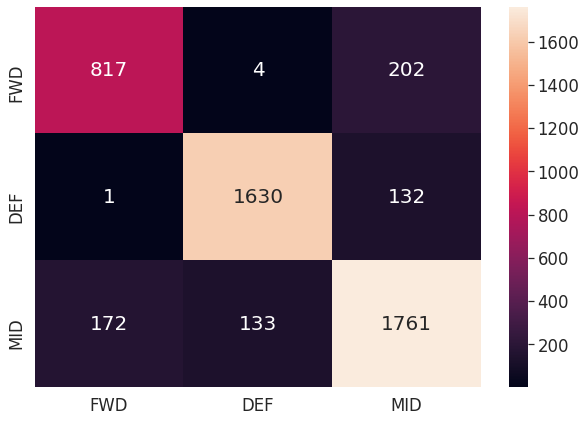

In [ ]:
# creating a heatmap from the confusion matrix
import seaborn as sn 
labels = ['FWD', 'DEF', 'MID'] # specifying the labels in our data based on encoding
#creating a dataframe from the confusion matrix
confusion_df = pd.DataFrame(confusion_matrix_lr2, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # setting the label size
# drawing the heat map along with displaying values in a digit format and setting the digit size
sn.heatmap(confusion_df, annot=True, fmt='d', annot_kws={'size': 20})

From the above confusion matrix, it is seen that out of 1023 forwards, the logistic regression model classified 817 forwards correctly. Similarly, for defenders, out of 1763, the model classified 1630 defenders accurately. Lastly, out of 2066 midfielders, the model classified 1761 midfielders truly. Our model is classifying defenders best then midfielders and then only forwards. In short, our model has a decent predictive power since the number of true positives and true negatives are very high than the number of false positives and false negatives. The only concern is that this model is classifying many forwards as midfielders. This may be due to the fact that forwards share some attributes which are also found in midfielders. 

Saving the Model:

In [ ]:
import pickle
#from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, OneVsRest

lr2 = LogisticRegression(labelCol='Target', featuresCol='Scaled_features', maxIter=300, regParam=0.0, elasticNetParam=1.0)
model = lr2.fit(train)
predict_train = model.transform(train)
predict_test = model.transform(test)

In [ ]:
filename = 'best_model'
outfile = open(filename, 'wb')
pickle.dump(model, outfile)
outfile.close()

In [ ]:
from pyspark.ml.classification import LogisticRegressionModel
model.save('best_model')
sameModel = LogisticRegressionModel.load('best_model')

In [ ]:
# creating a zip file to download later
!zip -r /content/best_model.zip /content/best_model
# downloading the file
from google.colab import files
files.download('/content/best_model.zip')

  adding: content/best_model/ (stored 0%)
  adding: content/best_model/metadata/ (stored 0%)
  adding: content/best_model/metadata/._SUCCESS.crc (stored 0%)
  adding: content/best_model/metadata/.part-00000.crc (stored 0%)
  adding: content/best_model/metadata/part-00000 (deflated 46%)
  adding: content/best_model/metadata/_SUCCESS (stored 0%)
  adding: content/best_model/data/ (stored 0%)
  adding: content/best_model/data/._SUCCESS.crc (stored 0%)
  adding: content/best_model/data/.part-00000-97b326c6-7f98-4a5b-96f7-63e659458864-c000.snappy.parquet.crc (stored 0%)
  adding: content/best_model/data/part-00000-97b326c6-7f98-4a5b-96f7-63e659458864-c000.snappy.parquet (deflated 60%)
  adding: content/best_model/data/_SUCCESS (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pr = sameModel.transform(test)

In [ ]:
confusion_matrix_lr2, metrics_lr2 = calculate_confusion_matrix(predict_test)
performance_lr2 = calculate_performance_metrics_position(metrics_lr2)

In [ ]:
# showing the comparison table
classifiers = ('Logistic Regression',)
comparison_table('FWD', classifiers, performance_lr2).show()
comparison_table('DEF', classifiers, performance_lr2).show()
comparison_table('MID', classifiers, performance_lr2).show()    

Forwards:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|     83.2| 79.43|   81.27|
+-------------------+---------+------+--------+

Defenders:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|    92.72| 91.95|   92.33|
+-------------------+---------+------+--------+

Midfielders:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|    83.59| 86.08|   84.82|
+-------------------+---------+------+--------+



In [ ]:
confusion_matrix_lr2, metrics_lr2 = calculate_confusion_matrix(pr)
performance_lr2 = calculate_performance_metrics_position(metrics_lr2)

In [ ]:
# showing the comparison table
classifiers = ('Logistic Regression',)
comparison_table('FWD', classifiers, performance_lr2).show()
comparison_table('DEF', classifiers, performance_lr2).show()
comparison_table('MID', classifiers, performance_lr2).show()    

Forwards:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|     83.2| 79.43|   81.27|
+-------------------+---------+------+--------+

Defenders:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|    92.72| 91.95|   92.33|
+-------------------+---------+------+--------+

Midfielders:
+-------------------+---------+------+--------+
|         Classifier|Precision|Recall|F1-score|
+-------------------+---------+------+--------+
|Logistic Regression|    83.59| 86.08|   84.82|
+-------------------+---------+------+--------+

